In [742]:
# this hack is needed for relative operations
# see: https://stackoverflow.com/questions/16981921/relative-imports-in-python-3/16985066
import repackage; repackage.up()
from src.lib.db_operations import vdw_connect
import pandas as pds
import matplotlib.pyplot as plt
import seaborn as sns

connection = vdw_connect() # connect to database
df_demographics = pds.read_sql("select * from demographics", connection) # load demographics data

connection.close() # close db connection

In [743]:
# df_demographics.head()

In [744]:
# find out the number each sex type
sex_count = df_demographics.groupby('SEX').size()
sex_count.head()

SEX
F    7343
M    5777
dtype: int64

(array([0, 1]), <a list of 2 Text xticklabel objects>)

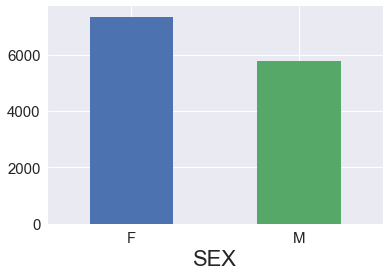

In [745]:
# visualize with simple bar plot
sex_count.plot.bar(fontsize=15)

# rotate x ticks
plt.xticks(rotation=0)

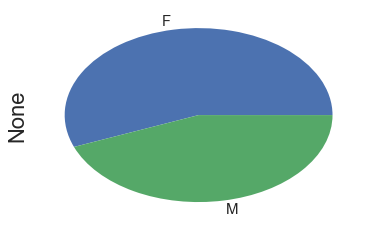

In [746]:
sex_count.plot.pie(fontsize=15) # simple pie chart

In [747]:
# add an age column using 2014 as the year
df_demographics["AGE"] = 2014 - df_demographics.BIRTH_YEAR.map(lambda x: int(x))
df_demographics.head()

,STUDY_ID,BIRTH_YEAR,SEX,RACE,ETHNICITY,AGE
0,100001,1926,F,WH,U,88
1,100002,1930,F,WH,U,84
2,100003,1941,M,WH,U,73
3,100004,1939,F,WH,U,75
4,100005,1926,F,WH,U,88


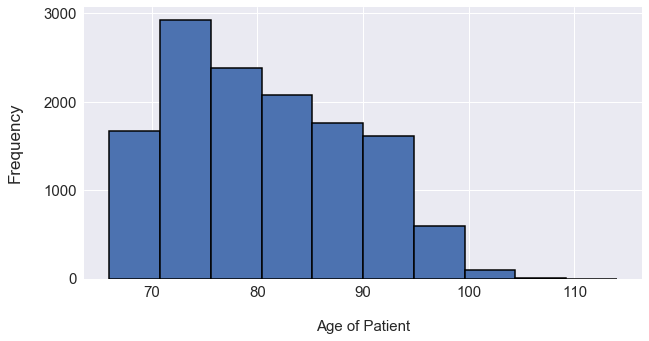

In [748]:
# show distribution of age of patients
ax = df_demographics["AGE"].plot(kind='hist', edgecolor='black', linewidth=1.5, fontsize=15, figsize=(10,5))

# configure labels; note use of '\n' to create space
ax.set_xlabel("\nAge of Patient", fontsize=15)
ax.set_ylabel("Frequency\n", fontsize=17)

plt.show() # shows the figure w/o extra text that can sometimes appear

In [749]:
# lets looks at tooth restorations
sql = """
SELECT STUDY_ID, ADATE, ADA_CODE, TOOTH, SURFACE_B, SURFACE_D, SURFACE_I, SURFACE_L, SURFACE_M, SURFACE_O
FROM VDW.`dental-procedure-diagnosis`
WHERE ADA_CODE LIKE 'D%'
AND TOOTH > 0
AND (SURFACE_B > 0
	 OR SURFACE_D > 0
     OR SURFACE_I > 0
     OR SURFACE_L > 0
     OR SURFACE_M > 0
     OR SURFACE_O > 0)
"""

# create dataframe with restoration info
connection = vdw_connect()
df_restorations = pds.read_sql(sql, connection)
connection.close()

df_restorations.head()

,STUDY_ID,ADATE,ADA_CODE,TOOTH,SURFACE_B,SURFACE_D,SURFACE_I,SURFACE_L,SURFACE_M,SURFACE_O
0,100001,03/2008,D2160,30,0,1,0,1,0,1
1,100002,06/2006,D2160,32,1,0,0,0,1,1
2,100002,08/2009,D2150,3,0,1,0,0,0,1
3,100002,08/2010,D2140,19,1,0,0,0,0,0
4,100003,09/2010,D2332,8,0,0,1,1,1,0


In [750]:
tooth_counts = df_restorations.groupby('TOOTH').size()
tooth_counts.head()

TOOTH
1     338
2    2598
3    3073
4    2011
5    2079
dtype: int64

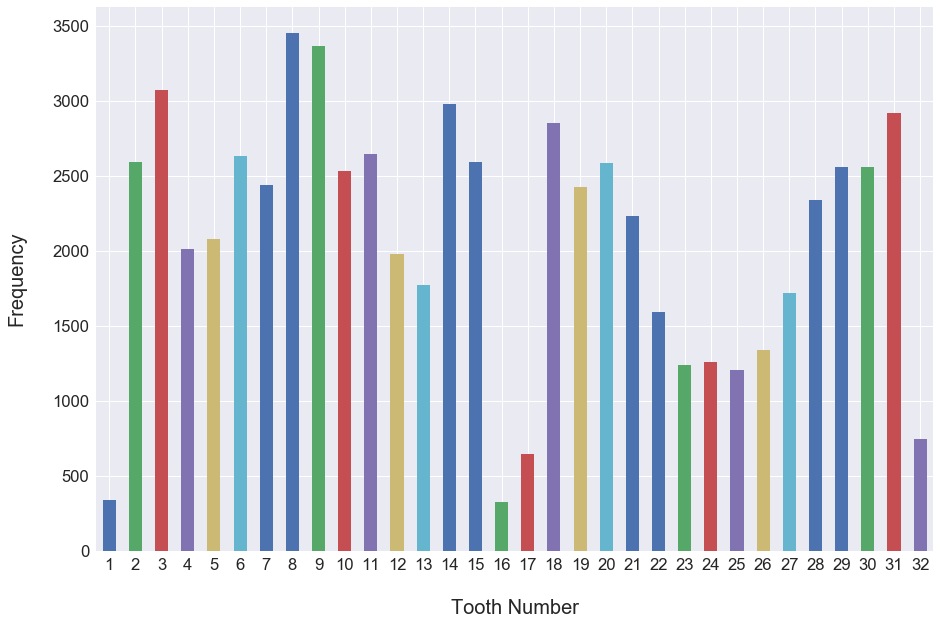

In [751]:
# draw bar chart
ax = tooth_counts.plot.bar(figsize=(15,10)) 

# rotate the ticks on the x axis
plt.xticks(rotation=0)

# configure labels
# note the use of '\n' to create space between ticks and labels
ax.set_xlabel("\nTooth Number", fontsize=20)
ax.set_ylabel("Frequency\n", fontsize=20)
ax.tick_params(labelsize='x-small')

plt.show()

In [752]:
# create dataframe of only suface info
df_surfaces = df_restorations[['SURFACE_M', 'SURFACE_O', 'SURFACE_D', 'SURFACE_B', 'SURFACE_L', 'SURFACE_I']]
df_surfaces.head()

,SURFACE_M,SURFACE_O,SURFACE_D,SURFACE_B,SURFACE_L,SURFACE_I
0,0,1,1,0,1,0
1,1,1,0,1,0,0
2,0,1,1,0,0,0
3,0,0,0,1,0,0
4,1,0,0,0,1,1


In [753]:
# calc number of surfaces restored for each surface
surface_counts = df_surfaces.apply(sum)
surface_counts.head()

SURFACE_M    23158
SURFACE_O    22181
SURFACE_D    27216
SURFACE_B    25487
SURFACE_L    20076
dtype: int64

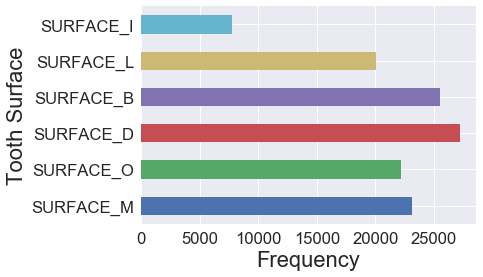

In [754]:
# create bar chart (flipped on its side) to show number of restorations per service
ax = surface_counts.plot.barh()

# configure labels
ax.set_xlabel("Frequency", fontsize=22)
ax.set_ylabel("Tooth Surface", fontsize=22)
ax.tick_params(labelsize='x-small')

plt.show()

In [755]:
# build dataframe patients' restorations and ages
# this could be done using an sql query, but for fun
# join on dataframes
df_merge = pds.merge(df_restorations, df_demographics, on='STUDY_ID', how='left')
df_merge = df_merge[['AGE', 'TOOTH', 'ADA_CODE']]
df_merge.head()

,AGE,TOOTH,ADA_CODE
0,88,30,D2160
1,84,32,D2160
2,84,3,D2150
3,84,19,D2140
4,73,8,D2332


In [764]:
# build dataframe with age by frequency of restorations
grouped = pds.DataFrame(df_merge.groupby('AGE').size())
grouped.reset_index(inplace=True)
grouped.columns = ['Age of Patient', 'Frequency']
grouped.head()

,Age of Patient,Frequency
0,66,219
1,67,1036
2,68,1495
3,69,1776
4,70,2245


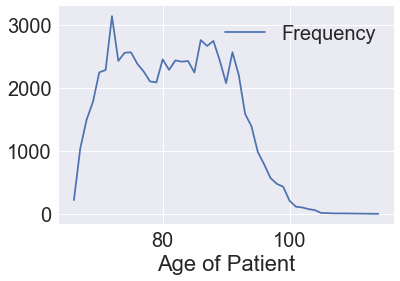

In [761]:
# create plot of age by restoration frequency
# the results will be similar to the histogram above
grouped.plot(kind='line', x='Age of Patient', y='Frequency')
plt.show()

In [757]:
# create a data structures to show a heatmap of teeth and surfaces
# build dataframe of tooth and surface info
df_tooth_surfaces = df_restorations[['TOOTH', 'SURFACE_M', 'SURFACE_O', 'SURFACE_D', 'SURFACE_B', 'SURFACE_L', 'SURFACE_I']]
df_tooth_surfaces.head()

,TOOTH,SURFACE_M,SURFACE_O,SURFACE_D,SURFACE_B,SURFACE_L,SURFACE_I
0,30,0,1,1,0,1,0
1,32,1,1,0,1,0,0
2,3,0,1,1,0,0,0
3,19,0,0,0,1,0,0
4,8,1,0,0,0,1,1


In [758]:
# for each tooth group, sum the surfaces restored
grouped_df = pds.DataFrame(df_tooth_surfaces.groupby('TOOTH').sum())
grouped_df.columns = ["M", "O", "D", "B", "L", "I"]
grouped_df.head()

,M,O,D,B,L,I
TOOTH,,,,,,
1,211,225,55,113,38,0
2,1306,1557,681,728,730,0
3,1134,1681,1225,644,1132,0
4,846,1127,1139,521,441,0
5,721,1188,1148,682,355,0


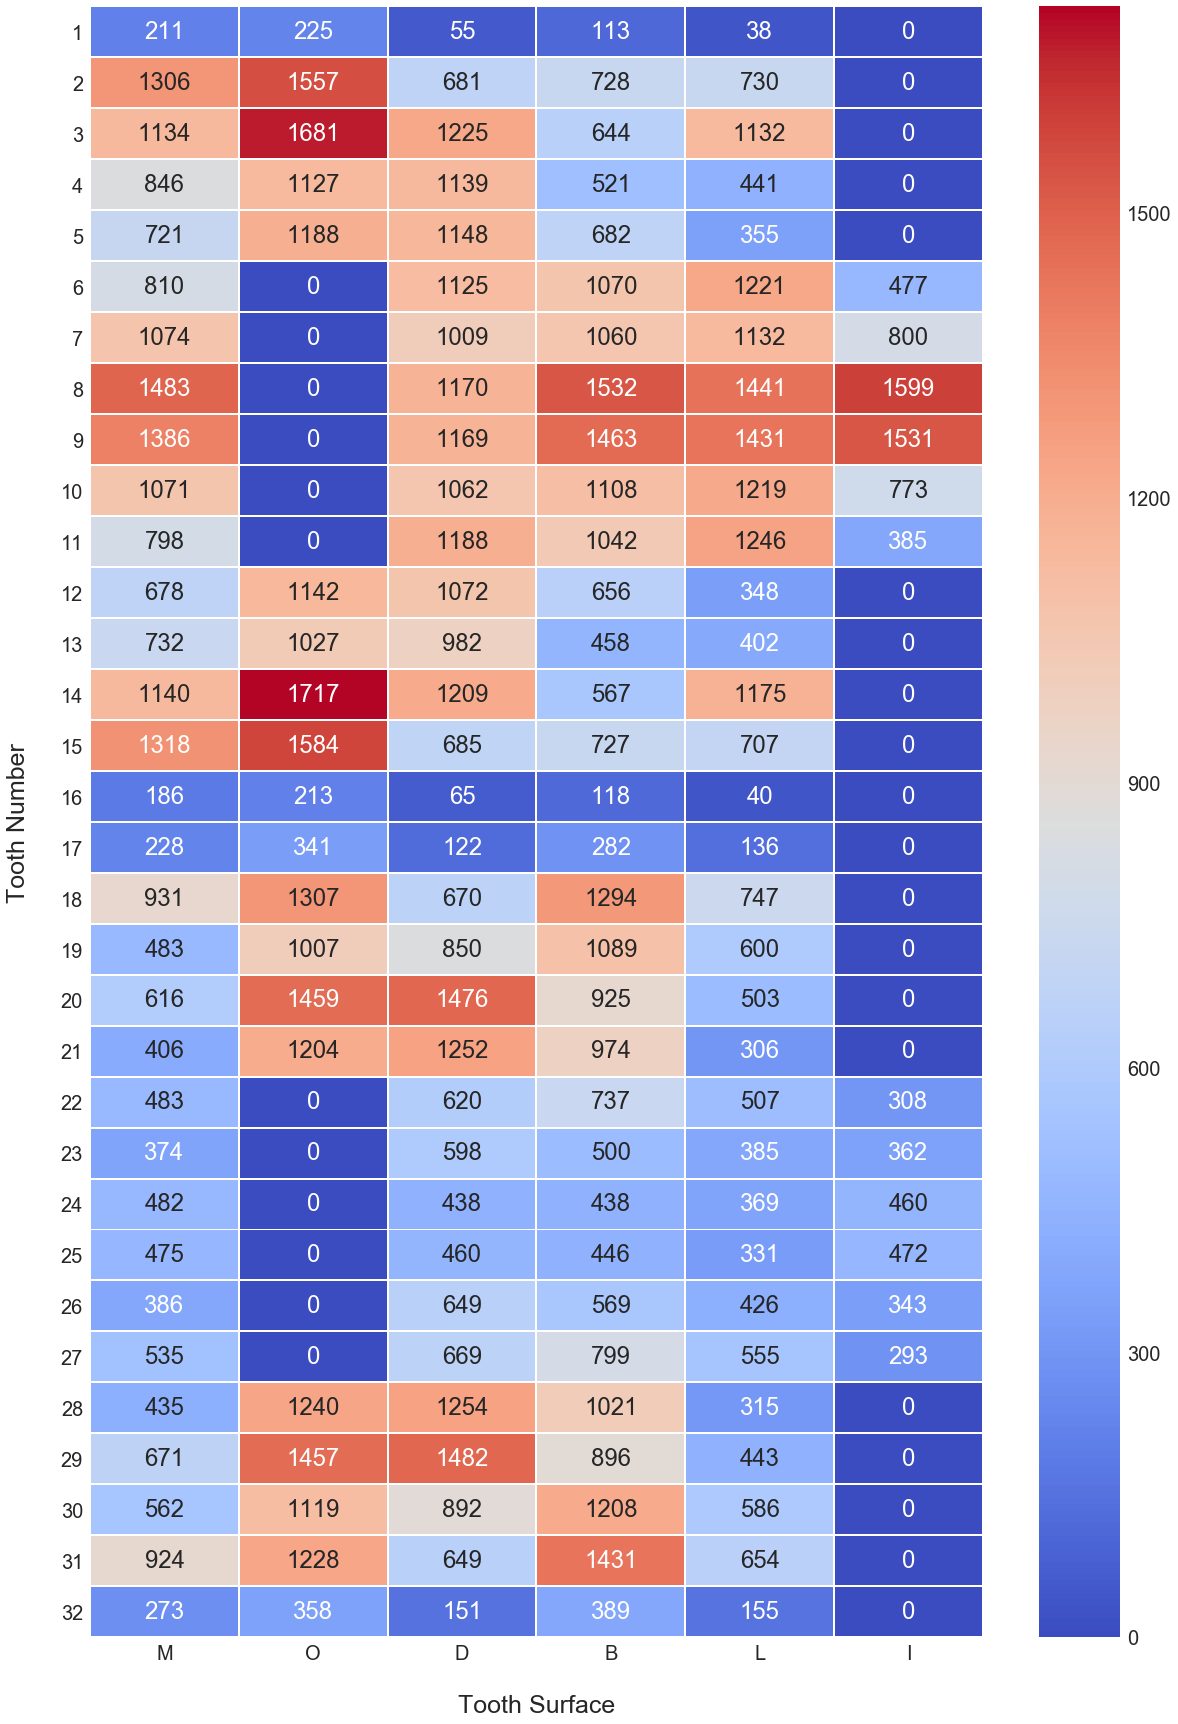

In [759]:
# make a heat map that shows the number of surfaces restored per tooth
# the surface is on the X axis, the tooth is on the Y axis

plt.figure(figsize = (20,30)) # this sets width and height of the figure

# fmt='d' means annotations are digits
# ax = sns.heatmap(grouped_df, cmap='RdYlBu_r', linewidths=1.0, annot=True, fmt='d') # playing around with some 
ax = sns.heatmap(grouped_df, cmap='coolwarm', linewidths=1.0, annot=True, fmt='d')   # color schemes in seaborn 

# rotate the ticks on the y axis
plt.yticks(rotation=0)

# configure X and Y labels
ax.set_xlabel("\nTooth Surface", fontsize=25)
ax.set_ylabel("Tooth Number\n", fontsize=25)
ax.tick_params(labelsize='small')

plt.show()